# Quickstart


In [13]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-openai

In [1]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, MessageGraph

model = ChatOpenAI(temperature=0)

graph = MessageGraph()

graph.add_node("oracle", model)
graph.add_edge("oracle", END)

graph.add_edge(START, "oracle")

runnable = graph.compile()

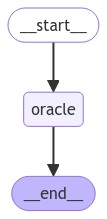

In [3]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
runnable.invoke(HumanMessage("What is 1 + 1?"))

[HumanMessage(content='What is 1 + 1?', id='28f82989-8a35-4c1e-b12d-aa1b54c2b5ea'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-aebd1367-b64d-4c25-971e-db7c88d55aac-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23})]

In [5]:
from typing import Literal

from langchain_core.tools import tool

from langgraph.graph import END, START
from langgraph.prebuilt import ToolNode


@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number


model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools(tools=[multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)
graph.add_edge(START, "oracle")
graph.add_edge("multiply", END)


def router(state: list[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return END


graph.add_conditional_edges("oracle", router)
runnable = graph.compile()

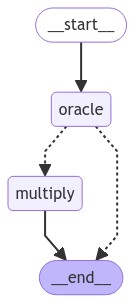

In [6]:
try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
runnable.invoke(HumanMessage("What is 123 * 456?"))

[HumanMessage(content='What is 123 * 456?', id='81692a54-acd4-4ef7-9ccf-49b2efc0b9b1'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XneG8vpjfal3lKO4q4fmfUYc', 'function': {'arguments': '{"first_number": 123, "second_number": 456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 57, 'total_tokens': 91}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2fe18a05-45bf-4cf6-ba29-c5956fc928bf-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_XneG8vpjfal3lKO4q4fmfUYc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 34, 'total_tokens': 91}),
 ToolMessage(content='56088', name='multiply', id='d494f0c9-daa8-4da2-aa4b-e9d4ace87912', tool_call_id='call_XneG8vpjfal3lKO4q4fmfUYc')]

In [8]:
runnable.invoke(HumanMessage("What is your name?"))

[HumanMessage(content='What is your name?', id='184ed583-58f1-4d4c-a428-d573b5a56286'),
 AIMessage(content='My name is Assistant. How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 54, 'total_tokens': 67}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-38dcd15d-8bdf-491a-b7ca-771bb64bb824-0', usage_metadata={'input_tokens': 54, 'output_tokens': 13, 'total_tokens': 67})]